# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [4]:
import numpy as np
import collections
from scipy import misc
from imp import reload
from labfuns import *
from sklearn import decomposition
from matplotlib.colors import ColorConverter

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [47]:
# Note that you do not need to handle the W argument for this part
# in: labels - N x 1 vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels,W=None):
    if W != None:
        priors = collections.defaultdict(float)
        for l, w in zip(labels, W):
            priors[l] += w
        return list(priors.values())
    else:
        return np.bincount(labels.astype(int)) / float(len(labels))

# Note that you do not need to handle the W argument for this part
# in:      X - N x d matrix of N data points
#     labels - N x 1 vector of class labels
# out:    mu - C x d matrix of class means
#      sigma - d x d x C matrix of class covariances
def mlParams(X,labels,W=None):
    N = len(X)
    d = len(X[0])
    classes = np.unique(labels)
    C = len(classes)    
    if W != None:
        mu = np.zeros((C,d))
        sum_W = collections.defaultdict(float)
        for x, label, w in zip(X, labels, W):
            mu[label] = np.add(mu[label], np.multiply(x, w))
            sum_W[label] += w
        for i in range(0, C):
            mu[i] = mu[i] / sum_W[i]
            
        sigma = np.zeros((d, d, C))
        for x, label, weight in zip(X, labels, W):
            xu = np.subtract(x, mu[label])
            sigma[:,:,label] = np.add(sigma[:,:,label], np.multiply(np.outer(xu, xu), w))
        for i in range(0, C):
            sigma[:,:,i] = np.divide(sigma[:,:,i], sum_W[i])
        
    else:
        class_members = [labels==c for c in classes]

        mu = np.zeros((C, d))
        for c in classes:
            members = X[class_members[int(c)], :]
            N = len(members)
            mu[c] = np.divide(members.sum(axis=0), N)

        sigma = np.zeros((d, d, C))
        for c in classes:
            members = X[class_members[int(c)], :]
            N = len(members)
            from_mean = np.subtract(members, mu[c])
            for el in from_mean:
                dot = np.outer(el, el)
                sigma[:, :, c] += np.divide(dot, N)
    
    return mu, sigma

def solve(A, b):
    L = np.linalg.cholesky(A)
    y = np.linalg.solve(L, b)
    x = np.linalg.solve(np.transpose(L), y)
    
    return x

# first = True
# in:      X - N x d matrix of M data points
#      prior - C x 1 vector of class priors
#         mu - C x d matrix of class means
#      sigma - d x d x C matrix of class covariances
# out:     h - N x 1 class predictions for test points
def classify(X,prior,mu,sigma,covdiag=True):
    #TODO: Add covdiag (Assignment 2.3)
    N = len(X)
    d = len(X[0])
    C = len(prior)
    h = np.zeros(N)
    
    for x_i, x in enumerate(X):
        cls = 0
        cls_prob = 0
        for c in range(0, C):

            xu = np.array(np.subtract(x, mu[c])).transpose()
            S_k = sigma[:, :, c]

            if covdiag:
                S_k = np.diag(np.diag(S_k))
                inverse = np.linalg.inv(S_k)
                inner = np.inner(xu.flatten(), inverse)
                second = np.inner(np.inner(xu.flatten(), inverse) ,xu.flatten())
                first =  np.log(np.linalg.det(sigma[:,:,c]))
            else:
#                 try:
                inverse = solve(S_k, xu)
#                 except Error:
#                     inverse = np.inner(np.linalg.inv(S_k), xu)
                second = np.inner(xu.flatten(), inverse)
                first = 2 * sum([np.log(S_k[i,i]) for i in range(0, d)])

            third = np.log(prior[c])
            prob = -0.5*first - 0.5*second + third
            if prob > cls_prob:
                cls_prob = prob
                cls = c
            
            h[x_i] = cls
    
    return h


## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

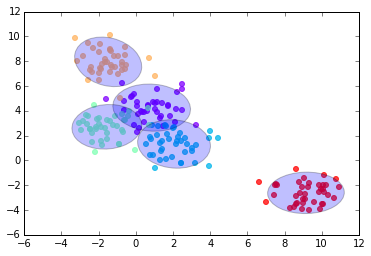

In [48]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

In [49]:
datasets = ['wine', 'iris', 'olivetti', 'vowel']
for dataset in datasets:
    for covdiag in [True,False]:
        print 'Output for dataset %s with covdiag=%s' % (dataset, covdiag)
        testClassifier(dataset=dataset, covdiag=covdiag)

Output for dataset wine with covdiag=True
Final mean classification accuracy  40.9056603774 with standard deviation 2.6667259991
Output for dataset wine with covdiag=False
Final mean classification accuracy  34.8113207547 with standard deviation 1.2336506444
Output for dataset iris with covdiag=True
Final mean classification accuracy  89.1555555556 with standard deviation 4.3804278499
Output for dataset iris with covdiag=False
Final mean classification accuracy  95.3111111111 with standard deviation 2.62739602583
Output for dataset olivetti with covdiag=True


/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:55: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyboardInterrupt: 

So, the results are for each dataset with the covdiag: 

Wine - **Covdiag**: 40.7 **!Covdiag**: 35.3 

Iris - **Covdiag**: 88.0 **!Covdiag**: 94.3 

Olivetti - **Covdiag**: 9.1 **!Covdiag**: 3.3 

Vowel - **Covdiag**: 55.0 **!Covdiag**: 75.4 

The independence assumption has a small positive effect on the dataset Wine and Olivetti, while having a  effect on Iris and a large negative effect on Vowel. For the Vowel dataset, there are a lot of features that are correlated, such as the frequencies that appear in the sound. Also, for the Iris plants, certain features will appear together more often. For the Wine and Olivetti dataset, it is not reasonable to assume that the same features of different examples will be related to each other, as for the Wines, the place where its brewed at does not really influence the chemical properties of the wine and for the Olivetti dataset, all the faces have different lighting and different expressions. The independence assumption can thus be reasonable if the features of the examples do not rely heavily on the class/source. 

The standard deviation is higher with a diagonal covariance matrix. This means that the classification with the full covariance matrix is more robust, as it gets more consistent results. It is therefore less sensitive to changes in the training data


# Testing the mlParams for a uniform weight vector

/Users/jan/Envs/skillable/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


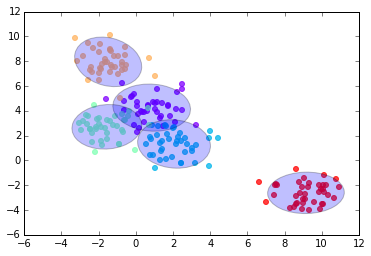

In [34]:
%matplotlib inline

X, labels = genBlobs(centers=5)
W = [1.0 / len(X)] * len(X)
mu, sigma = mlParams(X,labels,W)
plotGaussian(X,labels,mu,sigma)

As we can see the classification gives the same output as without weights, meaning the mlParams method is correctly implemented.

## Boosting functions to implement

The lab descriptions state what each function should do.

In [56]:
# in:       X - N x d matrix of N data points
#      labels - N x 1 vector of class labels
#           T - number of boosting iterations
# out: priors - length T list of prior as above
#         mus - length T list of mu as above
#      sigmas - length T list of sigma as above
#      alphas - T x 1 vector of vote weights 
def trainBoost(X,labels,T=5,covdiag=True):
    W = [1.0 / len(X)] * len(X)
    priors = []; mus = [];  sigmas = []; alphas = []
    for i in range(0, T):
        priors.append(computePrior(labels,W))
        mu, sigma = mlParams(X, labels, W)
        mus.append(mu)
        sigmas.append(sigma)
        H = classify(X, priors[i], mus[i], sigmas[i], covdiag)
        all_zipped = zip(W, H, labels)
        error = sum([w for w, h, l in all_zipped if h != l])
#         print error
        alpha = 0.5 * (np.log((1 - error) / (0.0001 if error == 0.0 else error)))
        for j in range(0, len(all_zipped)):
            weight_update = (np.exp(-alpha) if all_zipped[j][1] == all_zipped[j][2] else np.exp(alpha))
            W[j] = all_zipped[j][0] * weight_update
#         print weight_update
        alphas.append(alpha)
        W = np.true_divide(W, sum(W))
        
    return priors, mus, sigmas, alphas

# in:       X - N x d matrix of N data points
#      priors - length T list of prior as above
#         mus - length T list of mu as above
#      sigmas - length T list of sigma as above
#      alphas - T x 1 vector of vote weights
# out:  yPred - N x 1 class predictions for test points
def classifyBoost(X,priors,mus,sigmas,alphas,covdiag=True):
    # Your code here
    c = []
    print len(X)
    classifications = [classify(X, priors[i], mus[i], sigmas[i]) for i in range(0, len(priors))]
    class_array = np.array(classifications).transpose()
#     print class_array.shape
    for i in range(len(class_array)):
#         print len(class_array[i,:])
        weights = collections.defaultdict(float)
        for j in range(0, len(class_array[i,:])):
            weights[class_array[i,j]] += alphas[j]
        c.append(
            max(weights, key=weights.get)
        )
    print len(c)
    return c

# Testing our boosting function

In [30]:
datasets = ['olivetti', 'iris', 'olivetti', 'vowel']
for dataset in datasets:
    for covdiag in [True, False]:
        print 'Output for dataset %s with covdiag=%s' % (dataset, covdiag)
        testClassifier(dataset=dataset, covdiag=covdiag, doboost=True)

/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Output for dataset olivetti with covdiag=True
Final mean classification accuracy  7.24166666667 with standard deviation 1.65703466738
Output for dataset olivetti with covdiag=False


/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


KeyboardInterrupt: 

In [18]:
np.set_printoptions(threshold=np.nan)
np.set_printoptions(precision=25)
np.set_printoptions(linewidth=200)

def testClassifier(dataset='iris',dim=0,split=0.7,doboost=False,boostiter=5,covdiag=True,ntrials=100):

    X,y,pcadim = fetchDataset(dataset)

    means = np.zeros(ntrials,);

    for trial in range(ntrials):

        # xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplit(X,y,split)
        xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split)

        # Do PCA replace default value if user provides it 
        if dim > 0:
            pcadim = dim
        if pcadim > 0:     
            pca = decomposition.PCA(n_components=pcadim)
            pca.fit(xTr)
            xTr = pca.transform(xTr)
            xTe = pca.transform(xTe)     

        ## Boosting  
        if doboost:
            # Compute params
            priors,mus,sigmas,alphas = trainBoost(xTr,yTr,T=boostiter,covdiag=covdiag)
            yPr = classifyBoost(xTe,priors,mus,sigmas,alphas)        
        else:
        ## Simple
            # Compute params
            prior = computePrior(yTr)
            mu, sigma = mlParams(xTr,yTr)
            # Predict
            yPr = classify(xTe,prior,mu,sigma,covdiag=covdiag)

        # Compute classification error
#         print "Trial:",trial,"Accuracy",100*np.mean((yPr==yTe).astype(float))

        means[trial] = 100*np.mean((yPr==yTe).astype(float))

    print "Final mean classification accuracy ", np.mean(means), "with standard deviation", np.std(means)


## Plotting the decision boundary

This is some code that you can use for plotting the decision boundary
boundary in the last part of the lab.

In [32]:
def plotBoundary(dataset='iris',split=0.7,doboost=False,boostiter=5,covdiag=True):
    
    X,y,pcadim = fetchDataset(dataset)
    xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,split)
    pca = decomposition.PCA(n_components=2)
    pca.fit(xTr)
    xTr = pca.transform(xTr)
    xTe = pca.transform(xTe)
    
    pX = np.vstack((xTr, xTe))
    py = np.hstack((yTr, yTe))
     
    if doboost:
        ## Boosting
        # Compute params
        priors,mus,sigmas,alphas = trainBoost(xTr,yTr,T=boostiter,covdiag=covdiag)       
    else:
        ## Simple
        # Compute params
        prior = computePrior(yTr)
        mu, sigma = mlParams(xTr,yTr)

    xRange = np.arange(np.min(pX[:,0]),np.max(pX[:,0]),np.abs(np.max(pX[:,0])-np.min(pX[:,0]))/100.0)
    yRange = np.arange(np.min(pX[:,1]),np.max(pX[:,1]),np.abs(np.max(pX[:,1])-np.min(pX[:,1]))/100.0)

    grid = np.zeros((yRange.size, xRange.size))
    
    for (xi, xx) in enumerate(xRange):
        for (yi, yy) in enumerate(yRange):
            if doboost:
                ## Boosting 
                grid[yi,xi] = classifyBoost(np.matrix([[xx, yy]]),priors,mus,sigmas,alphas,covdiag=covdiag)        
            else:
                ## Simple
                grid[yi,xi] = classify(np.matrix([[xx, yy]]),prior,mu,sigma,covdiag=covdiag)
    
    classes = range(np.min(y), np.max(y)+1)
    ys = [i+xx+(i*xx)**2 for i in range(len(classes))]
    colormap = cm.rainbow(np.linspace(0, 1, len(ys)))

    plt.hold(True)
    conv = ColorConverter()
    for (color, c) in zip(colormap, classes):
        try:
            CS = plt.contour(xRange,yRange,(grid==c).astype(float),15,linewidths=0.25,colors=conv.to_rgba_array(color))
        except ValueError:
            pass
        xc = pX[py == c, :]
        plt.scatter(xc[:,0],xc[:,1],marker='o',c=color,s=40,alpha=0.5)
        
    plt.xlim(np.min(pX[:,0]),np.max(pX[:,0]))
    plt.ylim(np.min(pX[:,1]),np.max(pX[:,1]))
    plt.show()

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

Final mean classification accuracy  41.8301886792 with standard deviation 2.7349380396


/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:46: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jan/Envs/skillable/lib/python2.7/site-packages/ipykernel/__main__.py:55: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


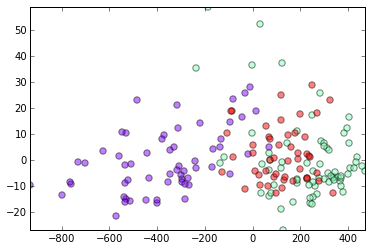

In [59]:
%matplotlib inline

# Example usage of the functions

testClassifier(dataset='wine',split=0.7,doboost=False,boostiter=5,covdiag=True)

plotBoundary(dataset='wine',split=0.7,doboost=False,boostiter=5,covdiag=True)